In [17]:
import geopandas as gpd
import os
import xarray as xr
import rioxarray as rxr
import rasterio as rio
# import regionmask
from fiona.crs import from_epsg 
from shapely.geometry import Point, Polygon
import h5py as h5
from glob import glob
import json
import dask as da
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rasterio.warp import reproject, Resampling

import warnings
warnings.filterwarnings("ignore")

In [18]:
def gen_extent_from_neon_h5(fi, nid='CPER'):
    
    ds = h5.File(fi, 'r')
    map_info = str(ds['CPER']['Reflectance']['Metadata']['Coordinate_System']['Map_Info'][()])
    epsg = int(ds['CPER']['Reflectance']['Metadata']['Coordinate_System']['EPSG Code'][()])
    data_shape = ds['CPER']['Reflectance']['Reflectance_Data'].shape
    
    # produce the affine transform components
    parts = [p.strip() for p in map_info.split(',')]
    aff = [float(p) for p in parts[1:7]]
    
    px, py, ul_x, ul_y = aff[:4]
    py = -py
    
    num_rows, num_cols, num_bands = data_shape
    
    # produce the points for the extent polygon
    ul = Point(ul_x, ul_y)
    ur = Point((ul_x +  num_cols*px), ul_y)
    ll = Point(ul_x, (ul_y + num_rows*py))
    lr = Point((ul_x + num_cols*px), (ul_y + num_rows*py))

    extent_poly = Polygon((ul, ur, lr, ll, ul))
    
    return extent_poly, epsg

# make function for reading h5 tiles
def read_h5_file(fi, nid='CPER'):
    # Read H5 file
    f = h5.File(fi, "r")
    
    # spectral
    wavelength = f[nid]['Reflectance']['Metadata']['Spectral_Data']['Wavelength'][:]
    fwhm = f[nid]['Reflectance']['Metadata']['Spectral_Data']['FWHM'][:]

    # CRS
    crs_str = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Coordinate_System_String'][()]
    crs_epsg = f[nid]['Reflectance']['Metadata']['Coordinate_System']['EPSG Code'][()]
    crs_mapinfo = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Map_Info'][()]
    crs_proj4 = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Proj4'][()]

    #arr = f[nid]['Radiance']['Radiance_Data'][:]
    arr = da.array.from_array(f[nid]['Reflectance']['Reflectance_Data'], chunks=(256,256,256))
    arr /= float(f[nid]['Reflectance']['Reflectance_Data'].attrs['Scale_Factor'])
    
    mapinfo_list = [a.strip() for a in str(crs_mapinfo).split(',')]
    mapinfo = [float(a) for a in mapinfo_list[1:7]]
    mapinfo
    pix_size = mapinfo[0]
    x = np.arange(mapinfo[2], mapinfo[2] + pix_size*arr.shape[1], pix_size)
    y = np.arange(mapinfo[3], mapinfo[3] - pix_size* arr.shape[0], -pix_size)

    xr_cube = xr.DataArray(arr, {'y': y, 'x': x, 'bands': wavelength}, dims=['y', 'x', 'bands'])
    xr_cube_ma = xr_cube.where(xr_cube != -9999)
    
    # add in CRS assignemnt!!!!!!!!!!!!
    xr_cube_ma = xr_cube_ma.rio.write_crs(int(crs_epsg))
    
    return xr_cube_ma

def resample_h5_spectral(neon_file, weights_file):
    
    nis_ds = read_h5_file(neon_file)
    
    
    with open(weights_file, 'r') as fb:
        weights = json.load(fb)
    
    sample_bands = []
    for k in weights.keys():
        b_weights, b_ids = weights[k]
        sample_band = (nis_ds.isel(bands=b_ids)*np.array(b_weights)).sum(axis=-1)/ np.array(b_weights).sum()
        sample_bands.append(sample_band)
            
    
    sat_ds = xr.concat(sample_bands, dim=list(weights.keys())).rename({'concat_dim':'sat_band'}) # 'sat_band' will be new at dim=0
    
    return sat_ds

def check_valid_pixel_overlap(neon_file, geometry, weights_file):
    
    nis_ds = resample_h5_spectral(neon_file, weights_file)
    #print(nis_ds.spatial_ref)
    
    try:
        sample_clip = nis_ds.rio.clip([geometry])
        sample_im_clip = sample_clip.sel(sat_band='L8_Coastal')
        
        # count pixels vs total
        total_pixels = sample_im_clip.size
        gt0 = (sample_im_clip > 0.0).sum()
        valid_frac = gt0.values/total_pixels
        
        print(f'valid fraction: {valid_frac}')
        if valid_frac > 0.99:
            return valid_frac
        else:
            print('valid pixels are not above 99% of AOI, returning False')
            return valid_frac
    except Exception as e:
        
        print(e)
        print('not in bounds...')
        return 0.0

In [19]:
#geodataframe for file extents
h5_files = glob('../../NEON_spectrometer-orthorectified-surface-directional-reflectance---flightline-09132020/*.h5')
polys = [gen_extent_from_neon_h5(fi)[0] for fi in h5_files]
desc = [os.path.basename(fi).split('.')[0] for fi in h5_files]
epsg = gen_extent_from_neon_h5(h5_files[0])[1]

fl_gdf = gpd.GeoDataFrame({'geometry': polys, 'filename':desc}, crs=from_epsg(epsg))

<AxesSubplot:>

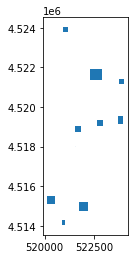

In [20]:
# load AOIS
aois = './aois/cper_aois.shp'
aoi_gdf = gpd.read_file(aois) # replace with shapefile or other
aoi_gdf['area_aoi'] = [g.area for g in aoi_gdf.geometry] # column for area
aoi_gdf.rename(columns={'desc_': 'desc'}, inplace=True)
aoi_gdf.plot()


In [21]:
# calculate the areas of overlap of AOI geometries within each flightline
aoi_overlap = gpd.overlay(fl_gdf, aoi_gdf, how='intersection')
aoi_overlap['area_ovr'] = aoi_overlap.geometry.area

# only save the ones that have full overlap
aoi_overlap = aoi_overlap.loc[aoi_overlap.area_ovr == aoi_overlap.area_aoi]
# aoi_overlap.area_ovr == aoi_overlap.area_aoi

In [22]:
# find the overlapping flightline with each aoi
l8_weights_file = './spectral_response/NIS_weights_L8.json'
overlap_series = []
for geom, desc in zip(aoi_gdf.geometry, aoi_gdf.desc):
    
    print(desc)
    #nfi = os.path.join('../NEON_spectrometer-orthorectified-surface-directional-reflectance---flightline', row[1]['filename'] + '.h5')
    overlaps = []
    for nfi in h5_files:
        
        vfac = check_valid_pixel_overlap(nfi, geom, l8_weights_file)
        overlaps.append(vfac)
        
    overlap_series.append(overlaps)

    
# aoi_fl_df = gpd.GeoDataFrame(series, crs=from_epsg(epsg))
# aoi_fl_df.reset_index()

tarp_outline_1
No data found in bounds. Data variable: truediv-5a09fdf2cc4c9efcb40dac5b452a5753
not in bounds...
No data found in bounds. Data variable: truediv-6b294353cc46ee73ff7723735bb012f5
not in bounds...
No data found in bounds. Data variable: truediv-95ba7407d08338d8c4a0ee2abf9f442a
not in bounds...
No data found in bounds. Data variable: truediv-28ab9db8d8f9be49e95b9a38d30575ec
not in bounds...
No data found in bounds. Data variable: truediv-92ce4b86a8119ad86fe71577fc8b2b5d
not in bounds...
valid fraction: 0.0
valid pixels are not above 99% of AOI, returning False
valid fraction: 1.0
valid fraction: 1.0
No data found in bounds. Data variable: truediv-c610427dfa61e026a4deeb7f242c0982
not in bounds...
No data found in bounds. Data variable: truediv-2fa8ef01eeee14e0d99f25d258948067
not in bounds...
No data found in bounds. Data variable: truediv-d12ce128b2908de003a1cf386f19f04b
not in bounds...
No data found in bounds. Data variable: truediv-741d1525f3417ccbce965f5557edb0fb
not i

No data found in bounds. Data variable: truediv-5ffcb3b9bfcff522e8a0bd14e8b7b148
not in bounds...
No data found in bounds. Data variable: truediv-8bfe41eccd13cbee3768545467fd1d8b
not in bounds...
No data found in bounds. Data variable: truediv-d7d8e2c4d7ae988a6fc2c7864c5e369e
not in bounds...
No data found in bounds. Data variable: truediv-c40c43d2acfc7f0f86a4defe417a1e70
not in bounds...
No data found in bounds. Data variable: truediv-65dff0cdd75ff0a881457407fddebda4
not in bounds...
No data found in bounds. Data variable: truediv-8e5b652bbe3dc1dc398e5d86c33790cd
not in bounds...
No data found in bounds. Data variable: truediv-531c44b1b2bdab4881db45ccabc557ef
not in bounds...
valid fraction: 0.0
valid pixels are not above 99% of AOI, returning False
valid fraction: 0.38304448378254913
valid pixels are not above 99% of AOI, returning False
valid fraction: 0.9242597792885998
valid pixels are not above 99% of AOI, returning False
valid fraction: 0.5042951761867441
valid pixels are not ab

In [23]:
ov_thresh=0.99

overlap_arr = np.array(overlap_series)
overlap_arr.max(axis=1)
list(zip(np.where(overlap_arr > ov_thresh)))

[(array([ 0,  0,  0,  1,  1,  1,  3,  4,  7,  8,  9, 10], dtype=int64),),
 (array([ 6,  7, 14,  6,  7, 14,  6,  3,  8,  0,  0,  8], dtype=int64),)]

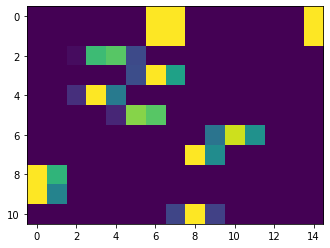

In [24]:
plt.imshow(overlap_arr)

In [25]:
rows, cols = np.where(overlap_arr > ov_thresh)
for i in range(rows.shape[0]):
    print(overlap_arr[rows[i], cols[i]])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


construct filename and geometry index pairs

In [26]:
# do this smartly
ov_idx = np.where(overlap_arr > ov_thresh)
_test = []
_temp_row, _temp_row_idx = [], []
for ix, a in enumerate(ov_idx[0]):
    if a in _temp_row:
        continue
    _temp_row.append(a)
    _temp_row_idx.append(ix)
    
for i,ix in enumerate(_temp_row_idx):
    _test.append((_temp_row[i], ov_idx[1][ix]))

# assign filename smartly
aoi_gdf['filename'] = None
for geomidx, fileidx in _test:
    aoi_gdf.at[geomidx,'filename'] = h5_files[fileidx]
    
       

In [27]:
aoi_gdf

,Shape_Leng,Shape_Area,desc,geometry,area_aoi,filename
0,56.563405,175.029482,tarp_outline_1,"POLYGON ((521558.002 4518008.657, 521558.170 4...",175.029482,../../NEON_spectrometer-orthorectified-surface...
1,54.479200,155.715737,tarp_outline_2,"POLYGON ((521576.763 4518020.205, 521576.763 4...",155.715737,../../NEON_spectrometer-orthorectified-surface...
2,2270.871600,322228.810508,riverbed_1,"POLYGON ((522306.667 4521898.897, 522883.033 4...",322228.810508,None
3,1348.775800,113548.628545,pond_1,"POLYGON ((521512.615 4519050.678, 521862.102 4...",113548.628545,../../NEON_spectrometer-orthorectified-surface...
4,1271.502000,100967.725783,rectangular_patch_1,"POLYGON ((522644.241 4519348.882, 522953.335 4...",100967.725783,../../NEON_spectrometer-orthorectified-surface...
5,1781.880200,197722.398591,pond_2,"POLYGON ((521750.166 4515215.188, 522168.782 4...",197722.398591,None
6,1611.686000,162327.746536,riverbed_2,"POLYGON ((520522.022 4515506.978, 520522.022 4...",162327.746536,None
7,749.269200,32507.902982,trees_1,"POLYGON ((520903.832 4514283.340, 521040.357 4...",32507.902982,../../NEON_spectrometer-orthorectified-surface...
8,1320.613200,101452.632694,veg_1,"POLYGON ((523719.494 4519531.704, 523962.764 4...",101452.632694,../../NEON_spectrometer-orthorectified-surface...
9,1059.018000,70005.110891,builtup_1,"POLYGON ((523777.942 4521429.533, 524033.218 4...",70005.110891,../../NEON_spectrometer-orthorectified-surface...


In [28]:
# try the resample_match technique for landsat
landsat_file = '../../OutputsL8/LS8_20200913_lat40lon10423_r32p33_vmsk_mclds_topshad_rad_srefdem_stdsref.tif'
landsat_ds = rxr.open_rasterio(landsat_file)
l8_weights_file = './spectral_response/NIS_weights_L8.json'

In [29]:
# try the resample_match technique for landsat
s2 = '../../OutputsSen2_10m_09132020/SEN2_20200913_lat41lon10435_T13TEF_ORB141_utm13n_vmsk_rad_srefdem.tif'
s2_ds = rxr.open_rasterio(s2)
s2_weights_file = './spectral_response/NIS_weights_S2A.json'

## loop over the geometries and do the groupby method to produce STD and MEAN per satellite pixel

In [30]:
# lists to store results
res_L8_means, res_S2_means, res_L8_stds, res_S2_stds =  [],[],[],[]
L8_arrs, S2_arrs = [],[]

# open the satellite image files
landsat_ds = rxr.open_rasterio(landsat_file)
s2_ds = rxr.open_rasterio(s2)
for desc, geom, fi in aoi_gdf.dropna()[['desc', 'geometry', 'filename']].values:
    
    print(desc)
    
    # spectral resample to each satellite
    neon_ds_L8 = resample_h5_spectral(fi, l8_weights_file)
    neon_ds_S2 = resample_h5_spectral(fi, s2_weights_file)
    
    # clip to current AOI
    neon_ds_L8 = neon_ds_L8.rio.clip([geom], all_touched=True, from_disk=True)
    neon_ds_S2 = neon_ds_S2.rio.clip([geom], all_touched=True, from_disk=True)
    
    # clip landsat and sentinel datasets, add to list
    L8_arrs.append(landsat_ds.rio.clip([geom], all_touched=True, from_disk=True))
    S2_arrs.append(s2_ds.rio.clip([geom], all_touched=True, from_disk=True))
    
    # group by for mean
    target_res = 30
    reduced_L8_mean = (
        neon_ds_L8
        .groupby(((neon_ds_L8.x//target_res) + 0.5) * target_res)
        .mean(dim='x')
        .groupby(((neon_ds_L8.y//target_res) + 0.5) * target_res)
        .mean(dim='y'))

    target_res = 10
    reduced_S2_mean = (
        neon_ds_S2
        .groupby(((neon_ds_S2.x//target_res) + 0.5) * target_res)
        .mean(dim='x')
        .groupby(((neon_ds_S2.y//target_res) + 0.5) * target_res)
        .mean(dim='y'))
    
    # group by for STD
    target_res = 30
    reduced_L8_std = (
        neon_ds_L8
        .groupby(((neon_ds_L8.x//target_res) + 0.5) * target_res)
        .std(dim='x')
        .groupby(((neon_ds_L8.y//target_res) + 0.5) * target_res)
        .std(dim='y'))

    target_res = 10
    reduced_S2_std = (
        neon_ds_S2
        .groupby(((neon_ds_S2.x//target_res) + 0.5) * target_res)
        .std(dim='x')
        .groupby(((neon_ds_S2.y//target_res) + 0.5) * target_res)
        .std(dim='y'))
    
    # append to lists
    res_L8_means.append(reduced_L8_mean)
    res_S2_means.append(reduced_S2_mean)
    res_L8_stds.append(reduced_L8_std)
    res_S2_stds.append(reduced_S2_std)


tarp_outline_1
tarp_outline_2
pond_1
rectangular_patch_1
trees_1
veg_1
builtup_1
trees_2


tarp_outline_1
array is too small for anything, continuing...
tarp_outline_2
array is too small for anything, continuing...
pond_1


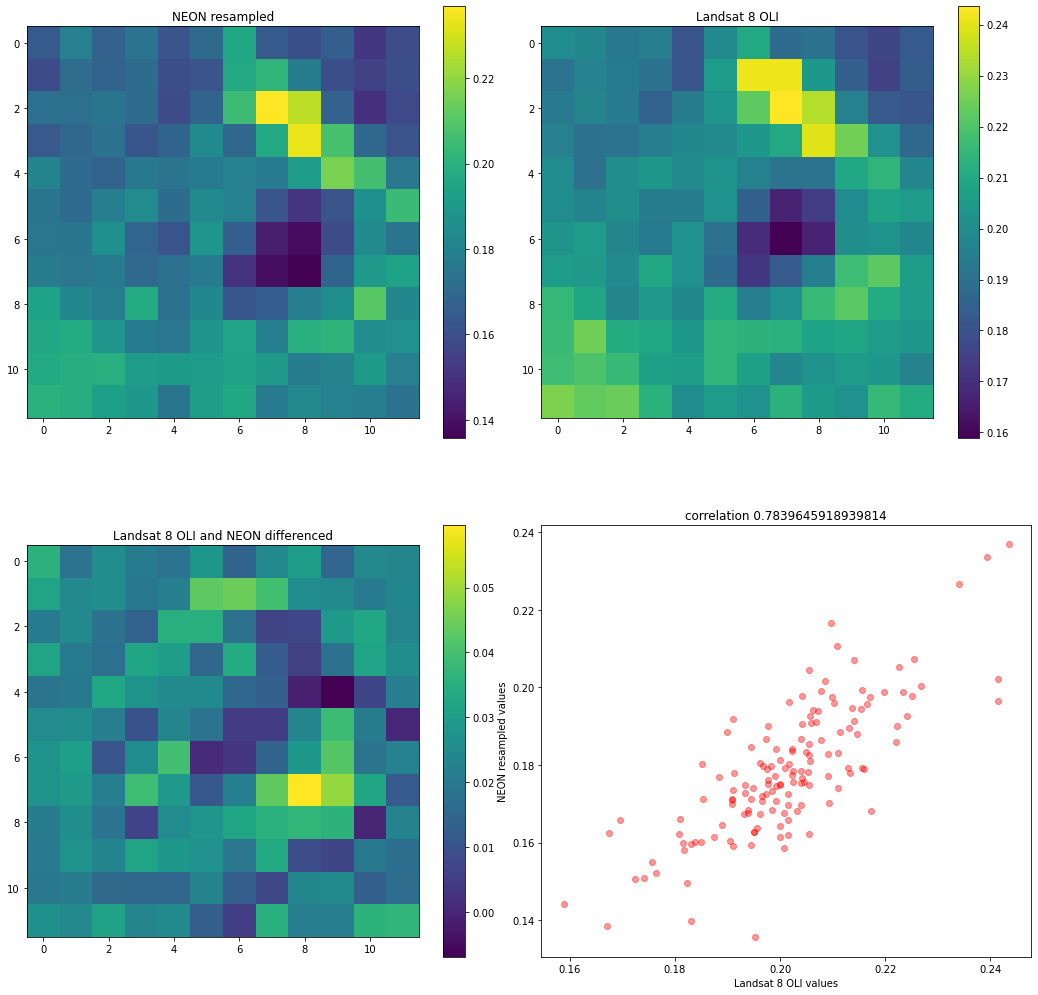

rectangular_patch_1


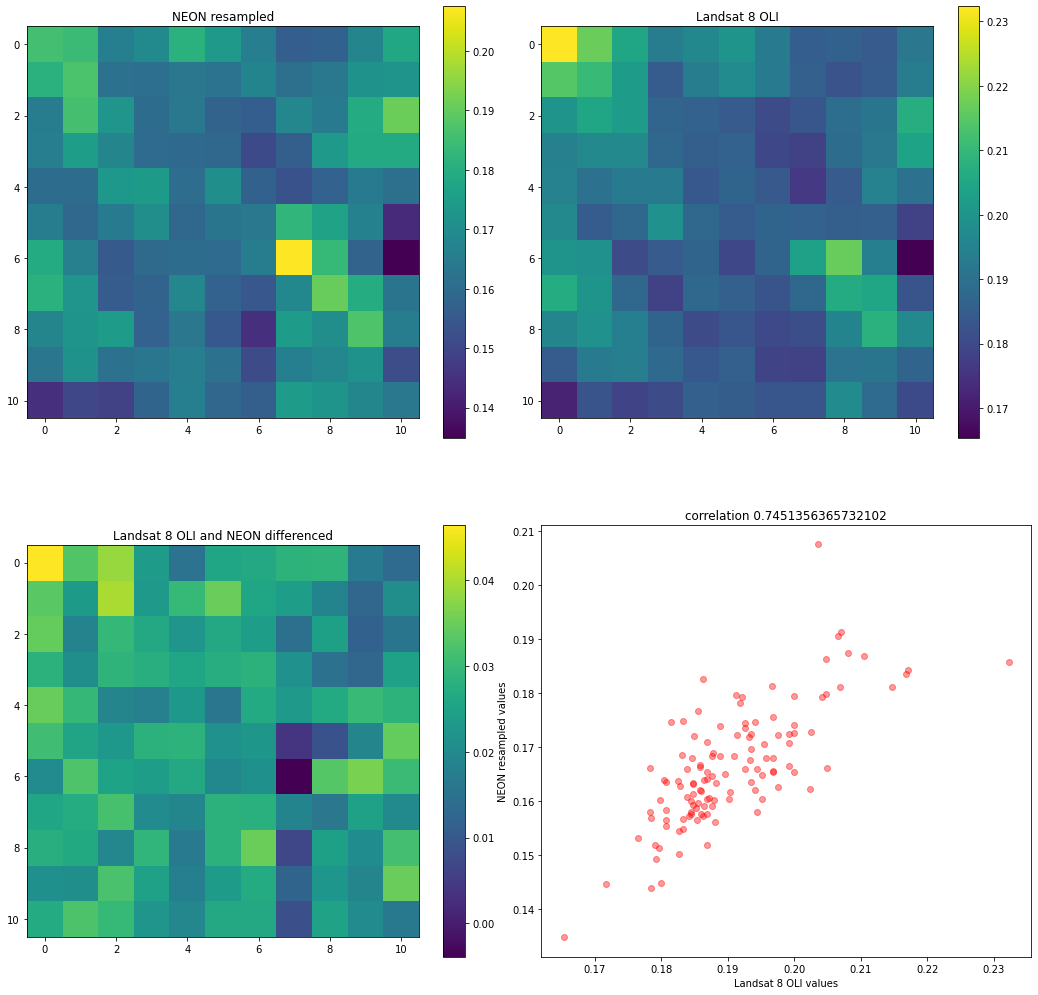

trees_1


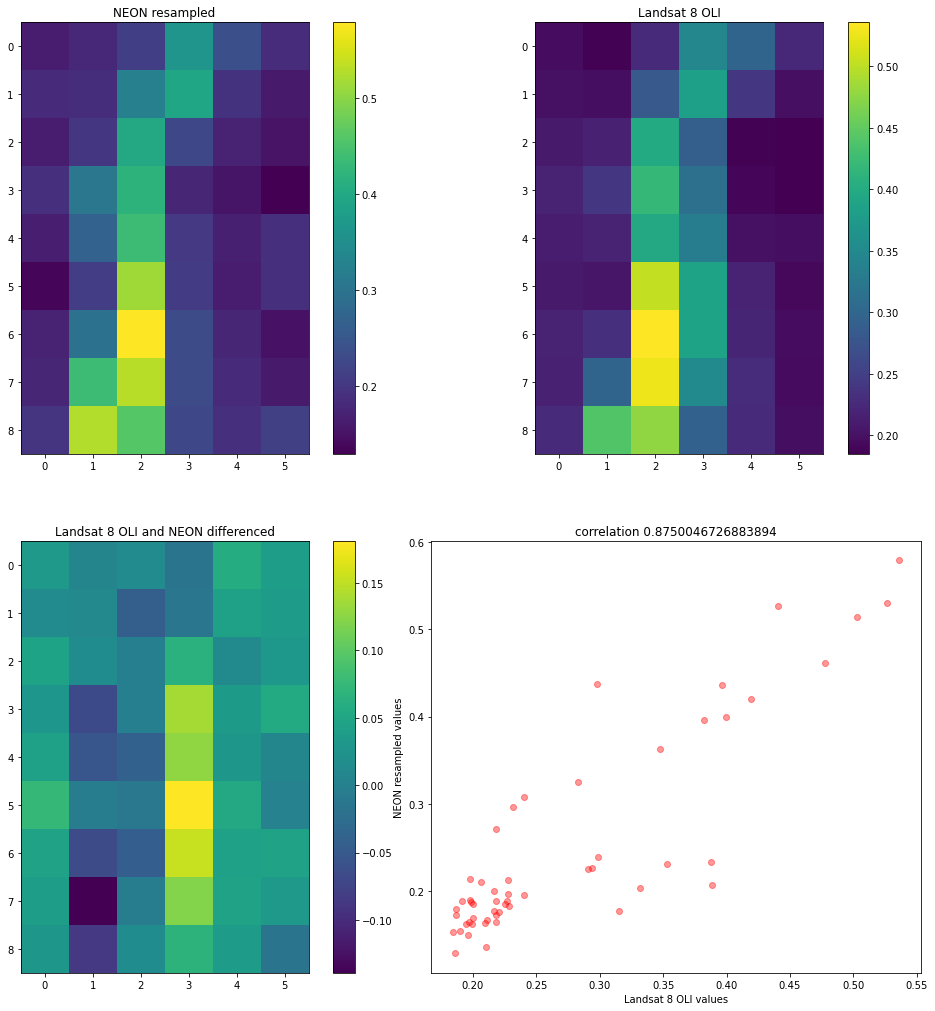

veg_1


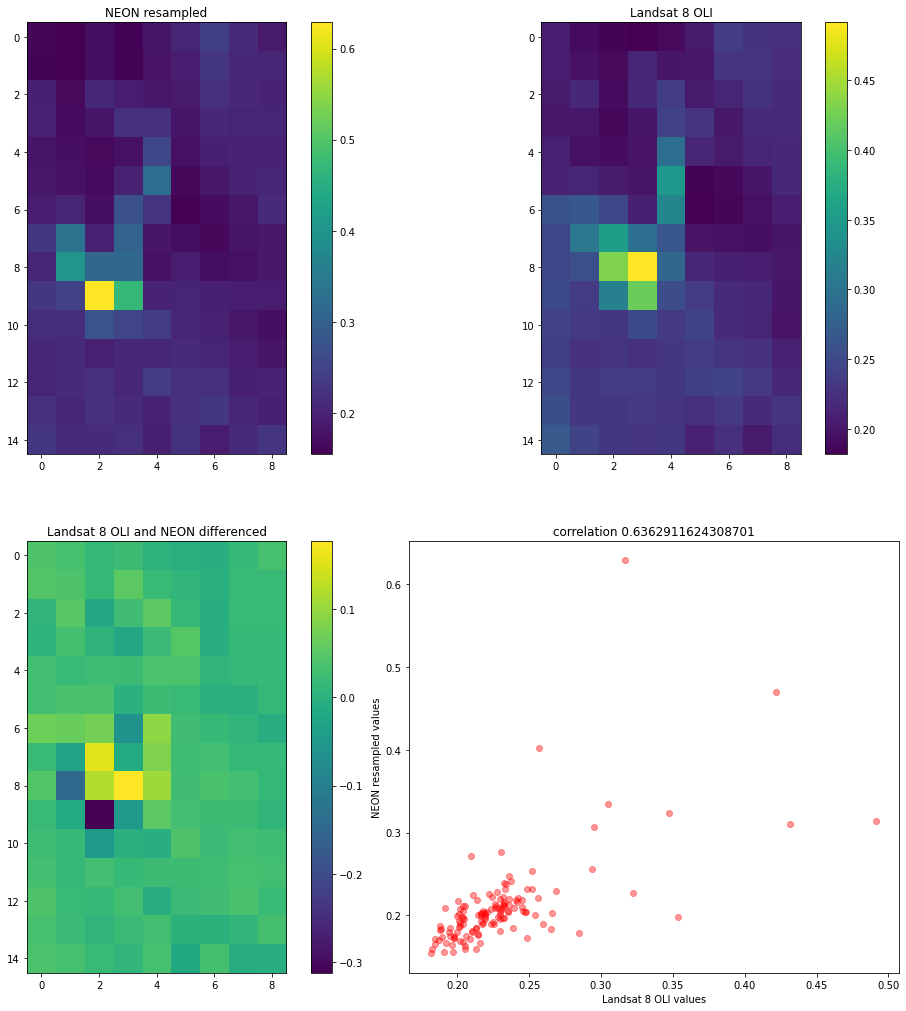

builtup_1


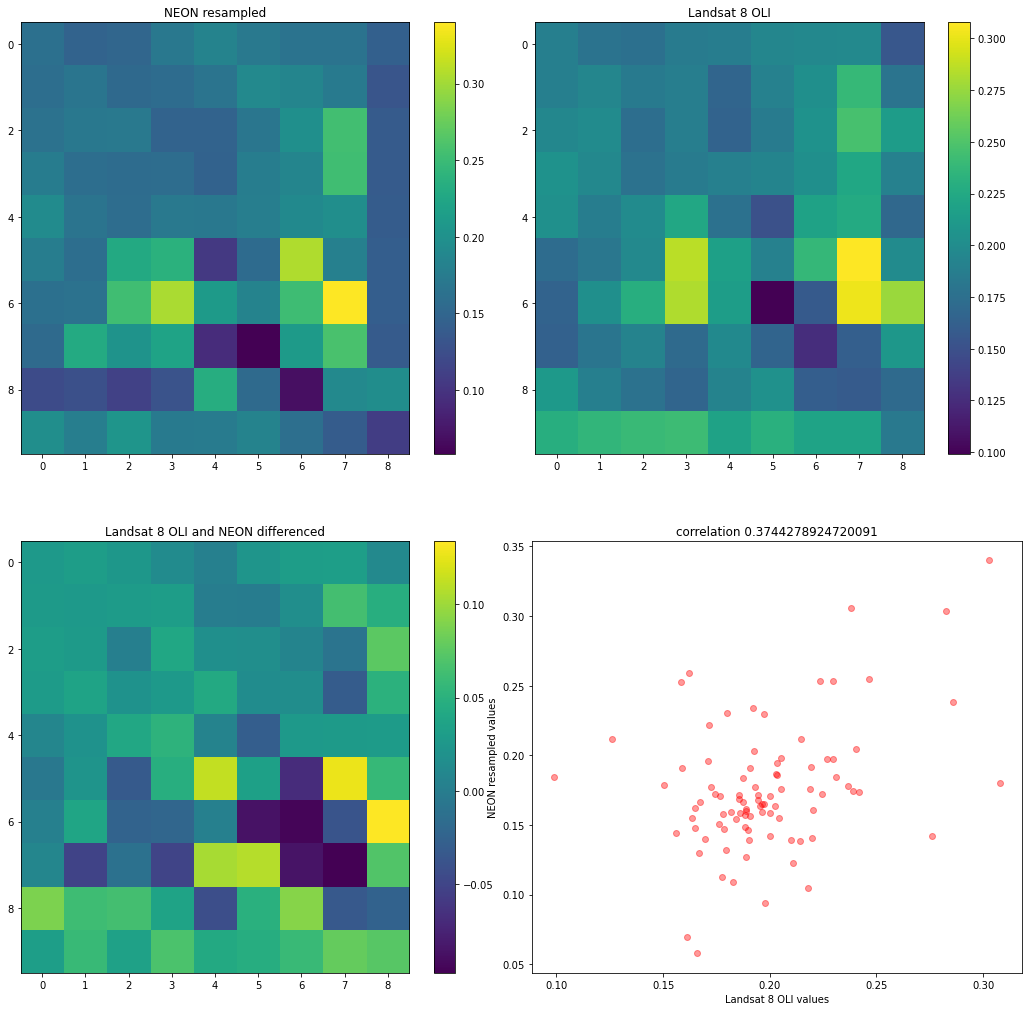

trees_2


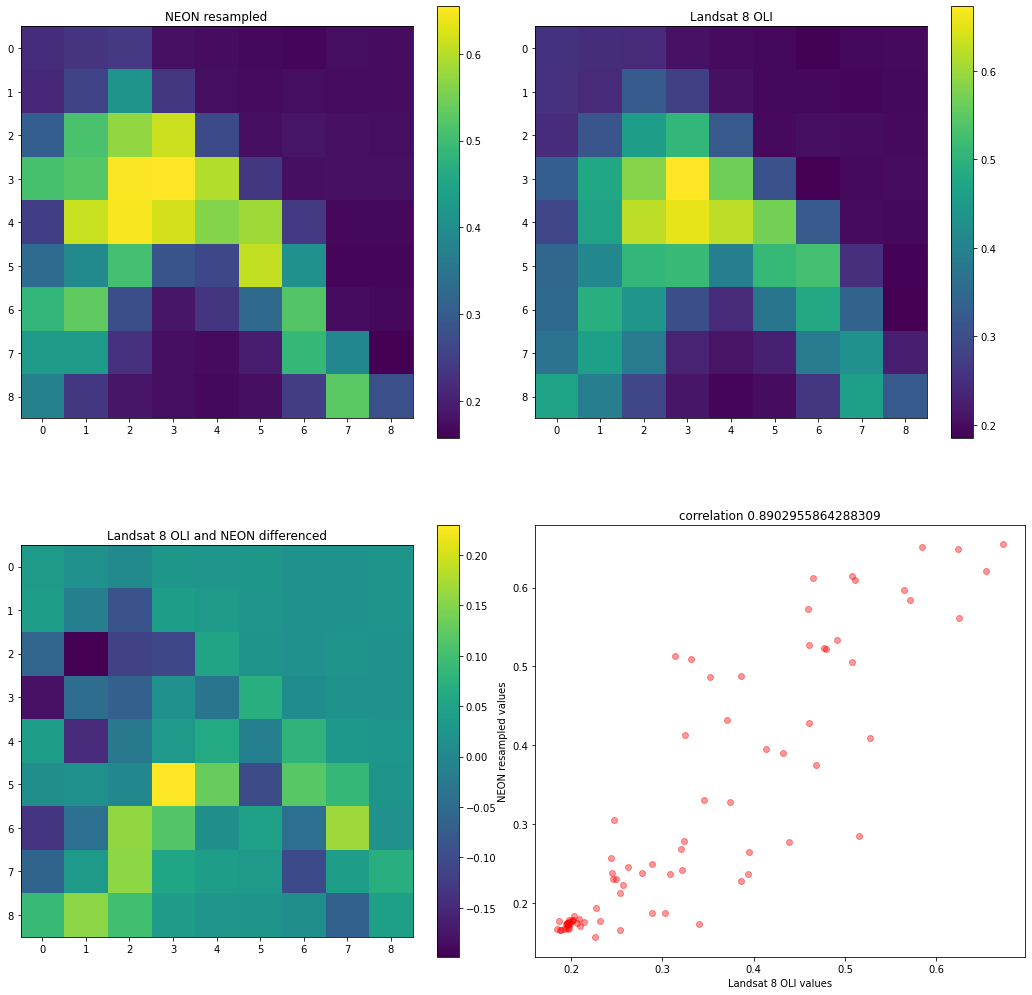

In [31]:
# plot Landsat 8 ndvi for AOIs
for desc, neon_L8, og_L8 in zip(aoi_gdf.dropna().desc.values, res_L8_means, L8_arrs):
    
    print(desc)
    # NEON NDVI
    neon_num = neon_L8.sel(sat_band='L8_NIR') - neon_L8.sel(sat_band='L8_Red')
    neon_den = neon_L8.sel(sat_band='L8_NIR') + neon_L8.sel(sat_band='L8_Red')
    neon_ndvi = neon_num / neon_den
    
    # Satellite NDVI
    sat_num = og_L8.sel(band=5) - og_L8.sel(band=4)
    sat_den = og_L8.sel(band=5) + og_L8.sel(band=4)
    sat_ndvi = (sat_num.astype('float')/10000) / (sat_den.astype('float')/10000)
    
    ## check shapes. if less than 2x2, fuhgeddaboutit
    neon_vals = np.flipud(neon_ndvi.values)
    sat_vals = sat_ndvi.values
    
    # hard threshold bad values
    neon_vals[neon_vals>1] = 1
    neon_vals[neon_vals<-1] = 1
    
    neon_shape = neon_vals.shape
    sat_shape = sat_vals.shape
    
    if 1 in np.array([neon_shape] + [sat_shape]):
        print('array is too small for anything, continuing...')
        continue
    
    # slice if necessary
    if neon_shape[0] < sat_shape[0]:
        sat_vals = sat_vals[:neon_shape[0],:]
            
    if neon_shape[1] < sat_shape[1]:
        sat_vals = sat_vals[:, :neon_shape[1]]
        
    if neon_shape[0] > sat_shape[0]:
        neon_vals = neon_vals[:sat_shape[0],:]
            
    if neon_shape[1] > sat_shape[1]:
        neon_vals = neon_vals[:, :sat_shape[1]]
    
    # get the correlation coefficient
    corr = np.ma.corrcoef(np.ma.masked_invalid(neon_vals.flatten()), np.ma.masked_invalid(sat_vals.flatten()))[0,1]
    
    # plot the NDVI
    fig, ax = plt.subplots(2,2, figsize=(15,15))
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
    
    im = ax[0,0].imshow(neon_vals)
    fig.colorbar(im, ax=ax[0,0])
    ax[0,0].set_title('NEON resampled')
    
    im = ax[0,1].imshow(sat_vals)
    fig.colorbar(im, ax=ax[0,1])
    ax[0,1].set_title('Landsat 8 OLI')
    
    im = ax[1,0].imshow(sat_vals - neon_vals)
    fig.colorbar(im, ax=ax[1,0])
    ax[1,0].set_title('Landsat 8 OLI and NEON differenced')
    
    
    ax[1,1].scatter(sat_vals.flatten(), neon_vals.flatten(), alpha=0.4, color='r')
    ax[1,1].set_xlabel('Landsat 8 OLI values')
    ax[1,1].set_ylabel('NEON resampled values')
    ax[1,1].set_title(f'correlation {corr}')
    plt.show()

tarp_outline_1


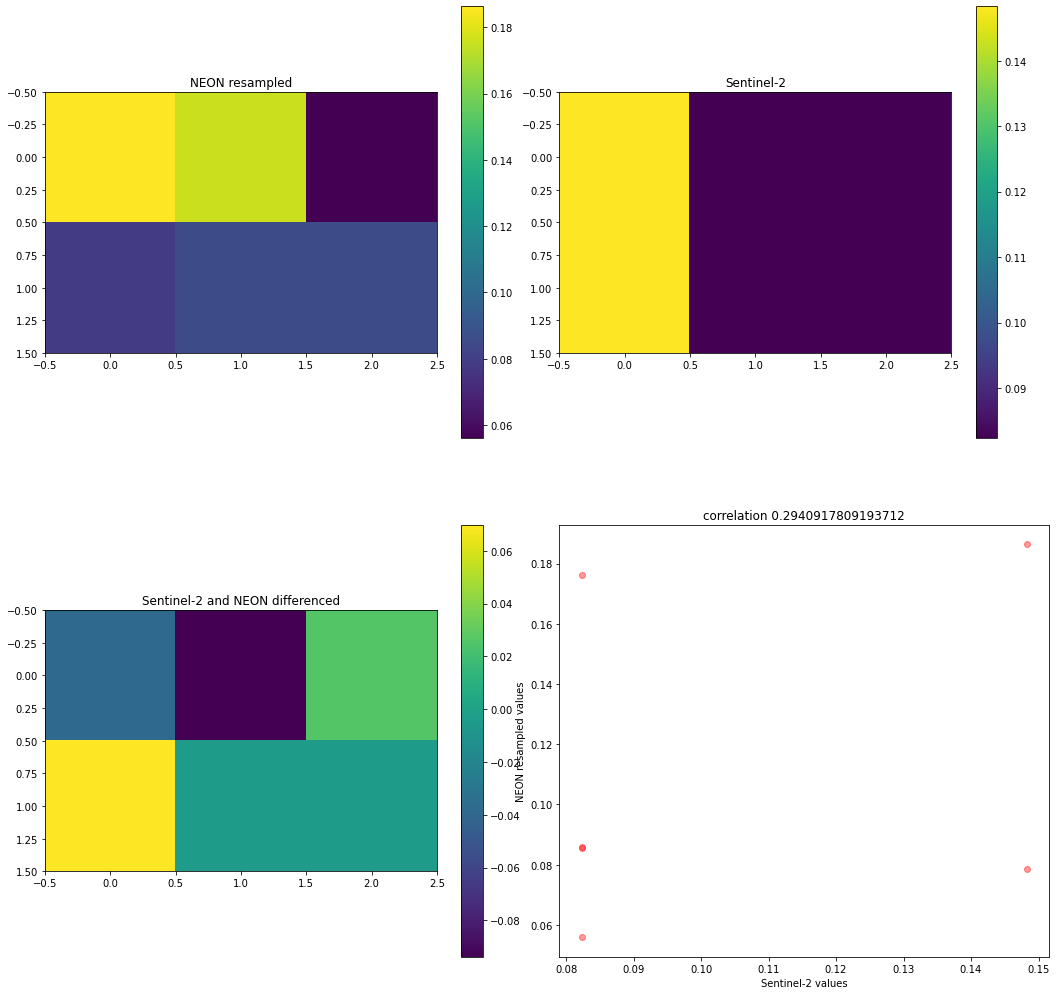

tarp_outline_2


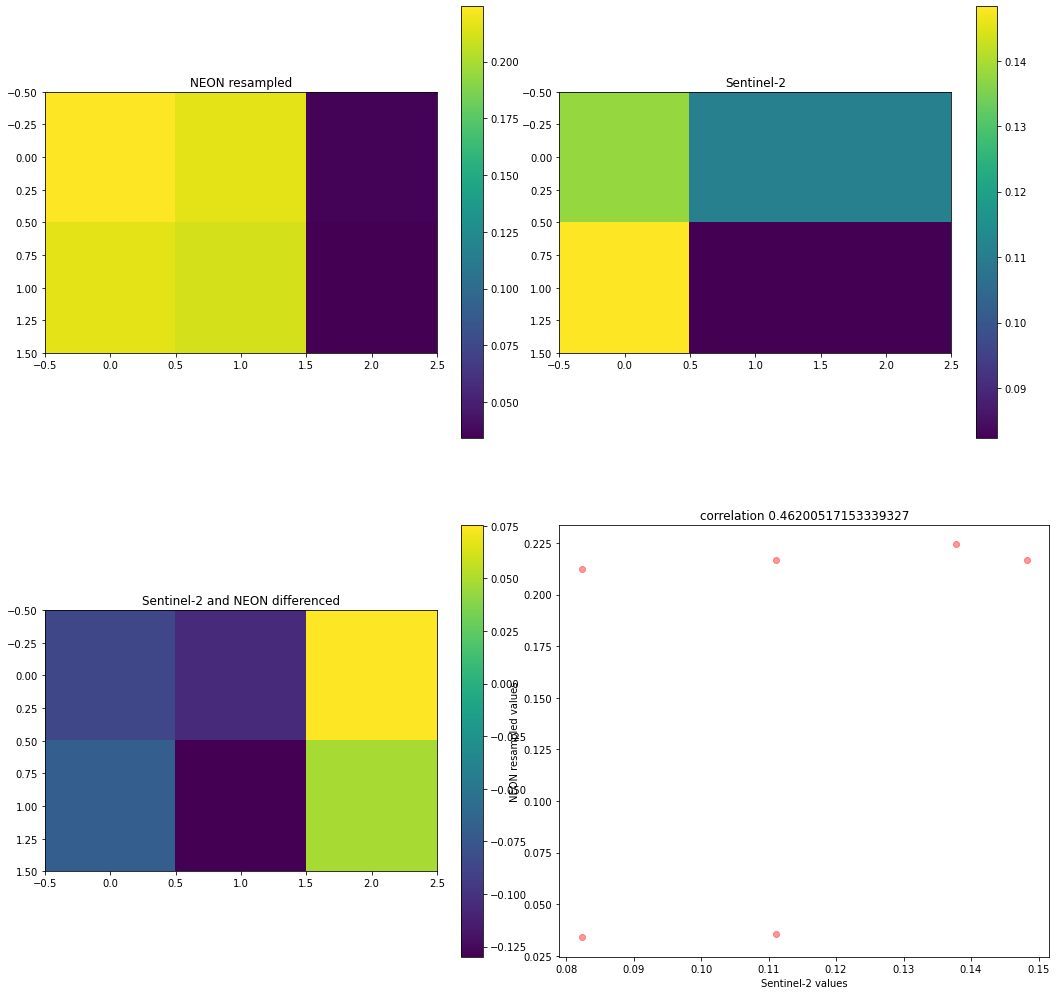

pond_1


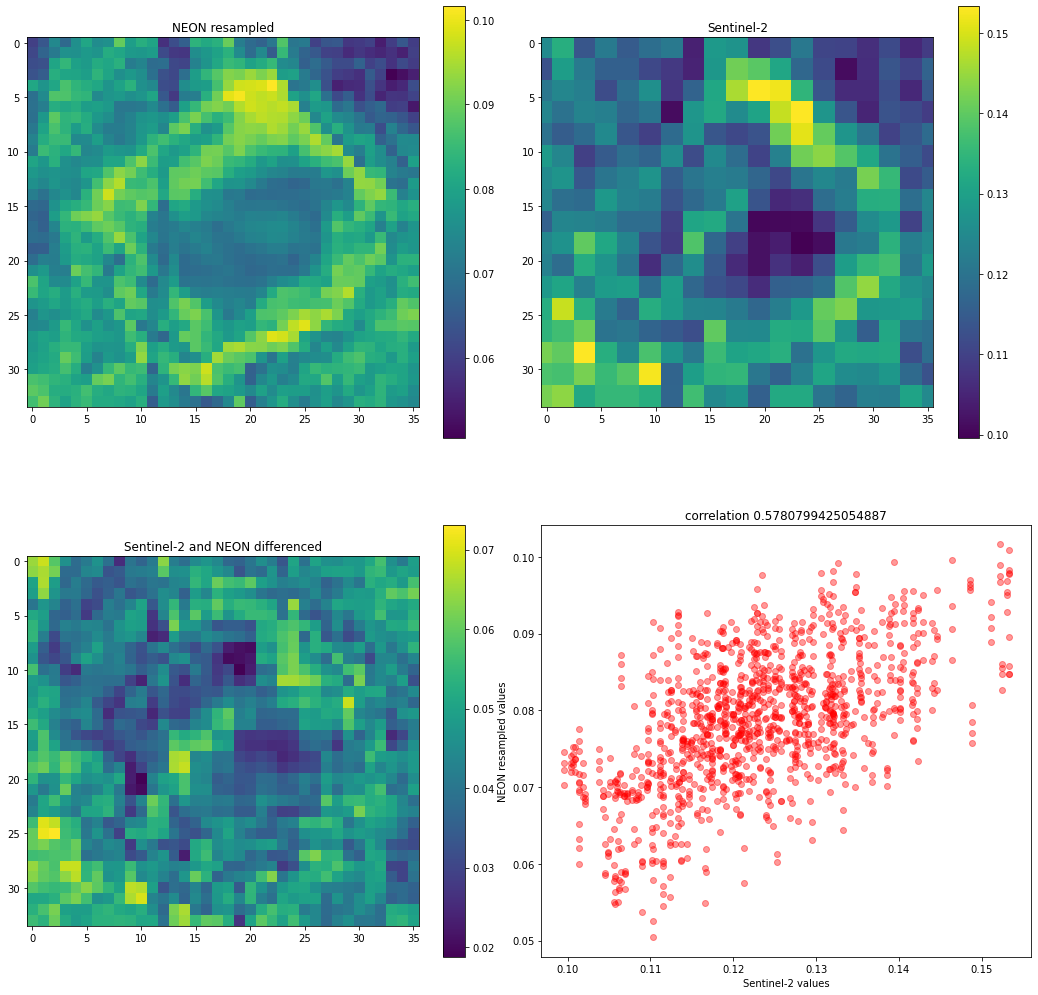

rectangular_patch_1


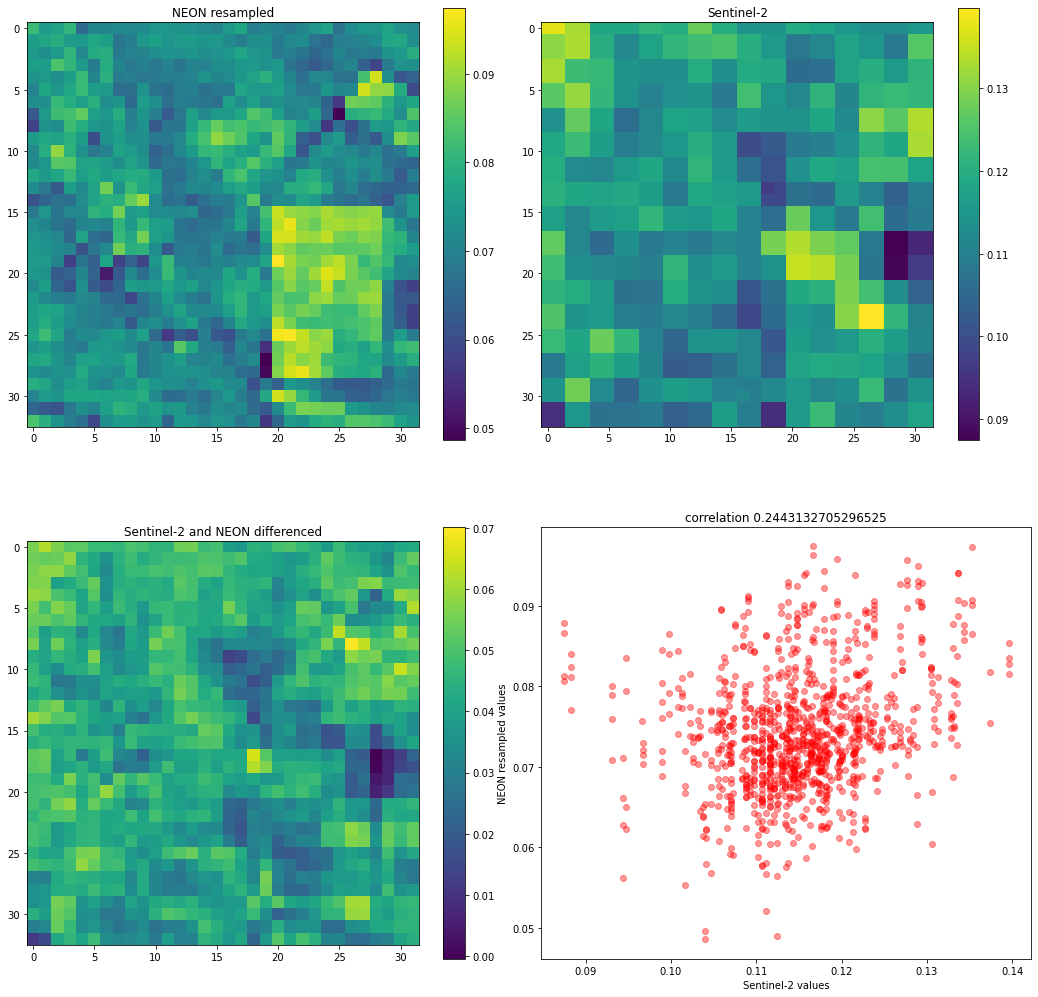

trees_1


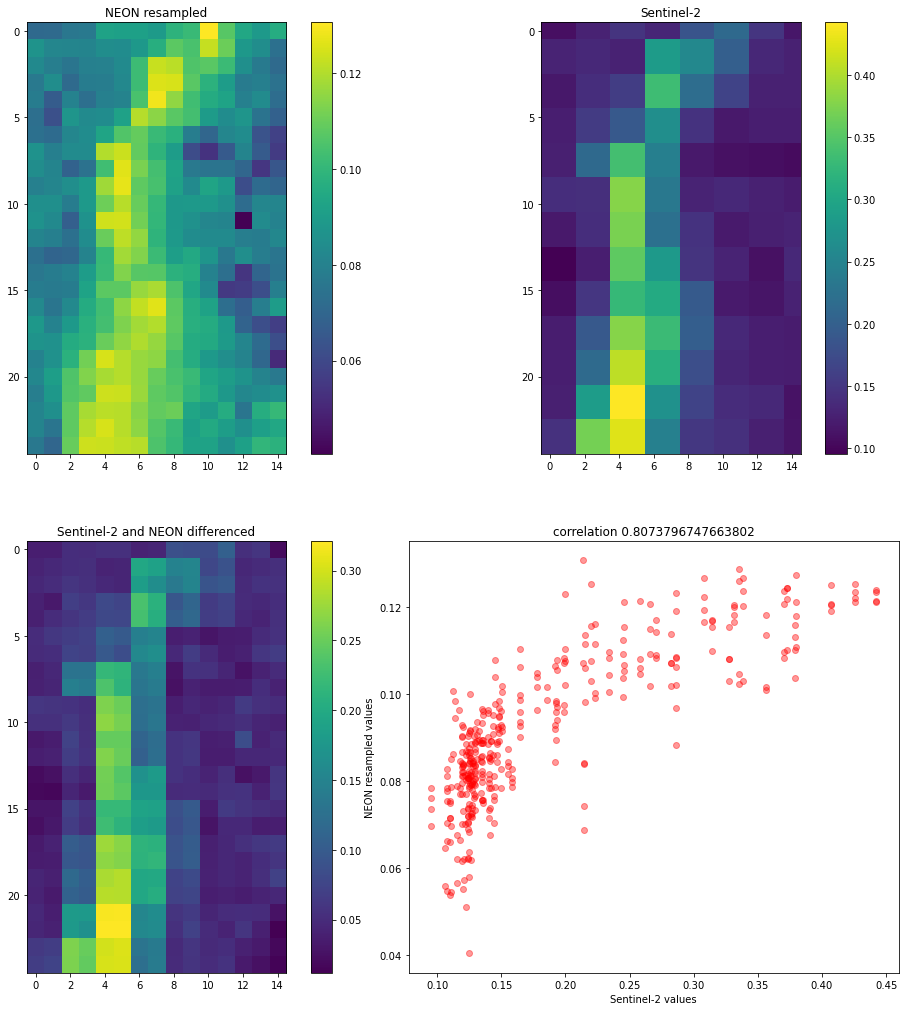

veg_1


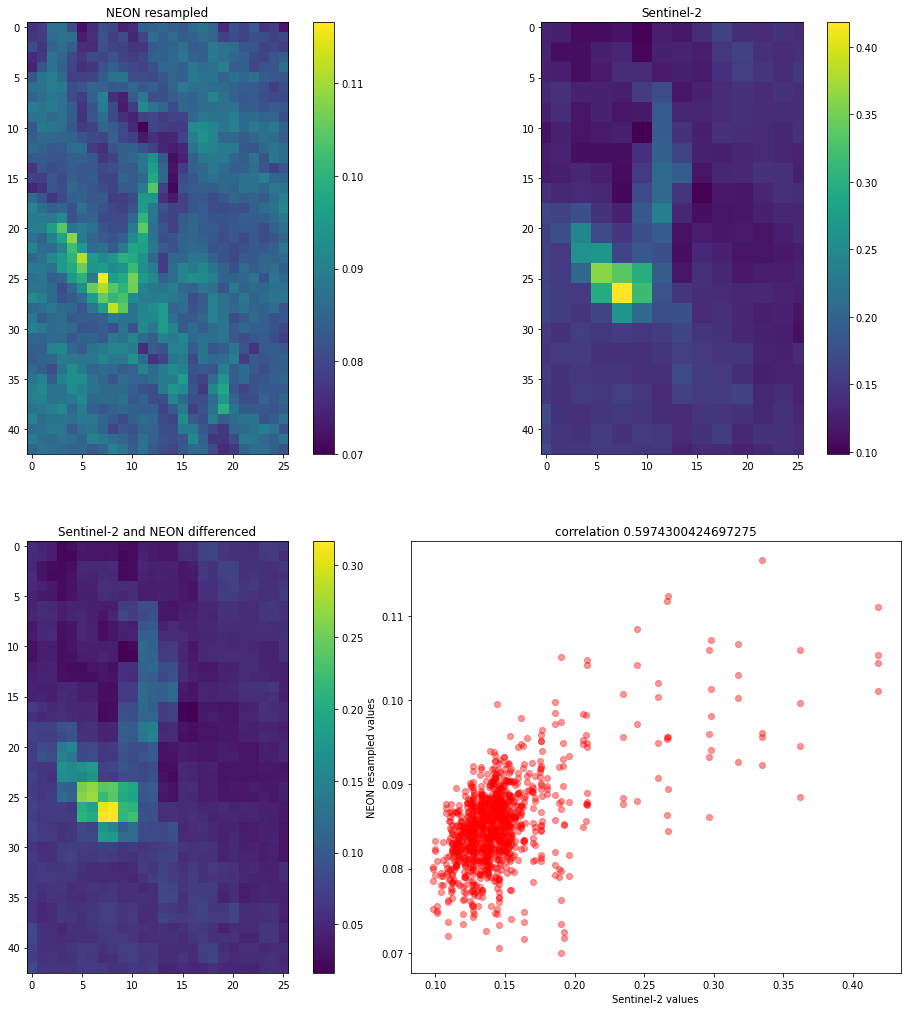

builtup_1


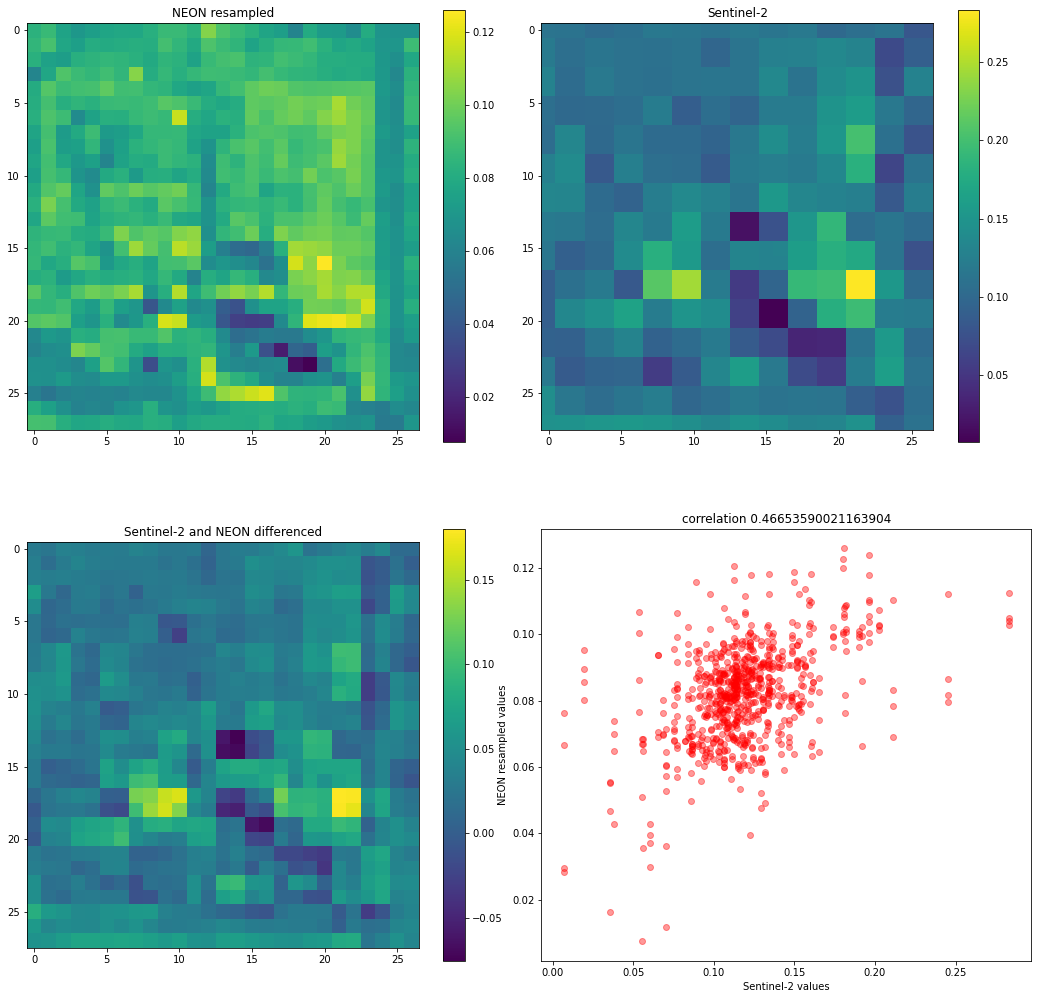

trees_2


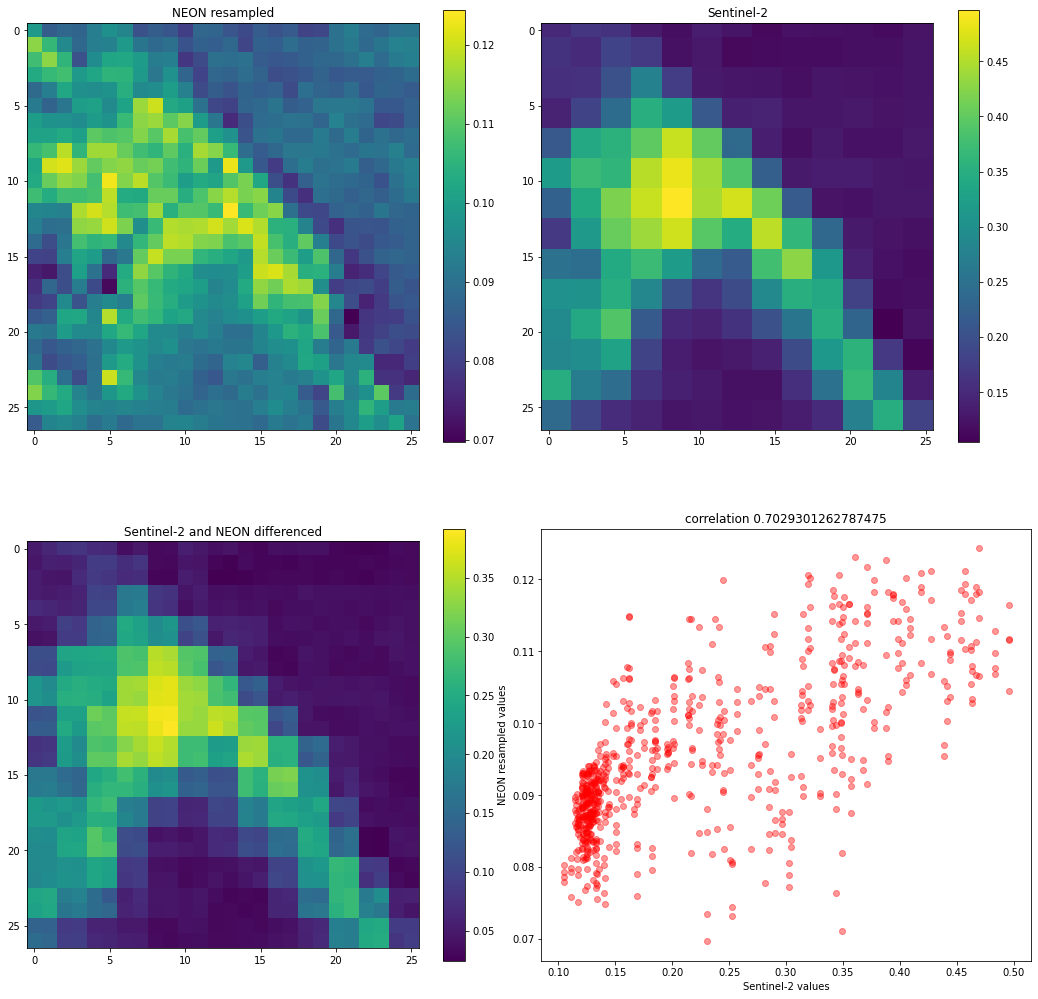

In [32]:
# plot Sentinel-2 8 ndvi for AOIs
for desc, neon_S2, og_S2 in zip(aoi_gdf.dropna().desc.values, res_S2_means, S2_arrs):
    
    print(desc)
    # NEON NDVI
    neon_num = neon_S2.sel(sat_band='S2A_B8') - neon_S2.sel(sat_band='S2A_B4')
    neon_den = neon_S2.sel(sat_band='S2A_B8') + neon_S2.sel(sat_band='S2A_B4')
    neon_ndvi = neon_num / neon_den
    
    # Satellite NDVI
    sat_num = og_S2.sel(band=8) - og_S2.sel(band=4)
    sat_den = og_S2.sel(band=8) + og_S2.sel(band=4)
    sat_ndvi = (sat_num.astype('float')/10000) / (sat_den.astype('float')/10000)
    
    ## check shapes. if less than 2x2, fuhgeddaboutit
    neon_vals = np.flipud(neon_ndvi.values)
    sat_vals = sat_ndvi.values
    
    # hard threshold bad values
    neon_vals[neon_vals>1] = 1
    neon_vals[neon_vals<-1] = 1
    
    neon_shape = neon_vals.shape
    sat_shape = sat_vals.shape
    
    if 1 in np.array([neon_shape] + [sat_shape]):
        print('array is too small for anything, continuing...')
        continue
    
    # slice if necessary
    if neon_shape[0] < sat_shape[0]:
        sat_vals = sat_vals[:neon_shape[0],:]
            
    if neon_shape[1] < sat_shape[1]:
        sat_vals = sat_vals[:, :neon_shape[1]]
        
    if neon_shape[0] > sat_shape[0]:
        neon_vals = neon_vals[:sat_shape[0],:]
            
    if neon_shape[1] > sat_shape[1]:
        neon_vals = neon_vals[:, :sat_shape[1]]
    
    # get the correlation coefficient
    corr = np.ma.corrcoef(np.ma.masked_invalid(neon_vals.flatten()), np.ma.masked_invalid(sat_vals.flatten()))[0,1]
    
    # plot the NDVI
    fig, ax = plt.subplots(2,2, figsize=(15,15))
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
    
    im = ax[0,0].imshow(neon_vals)
    fig.colorbar(im, ax=ax[0,0])
    ax[0,0].set_title('NEON resampled')
    
    im = ax[0,1].imshow(sat_vals)
    fig.colorbar(im, ax=ax[0,1])
    ax[0,1].set_title('Sentinel-2')
    
    im = ax[1,0].imshow(sat_vals - neon_vals)
    fig.colorbar(im, ax=ax[1,0])
    ax[1,0].set_title('Sentinel-2 and NEON differenced')
    
    
    ax[1,1].scatter(sat_vals.flatten(), neon_vals.flatten(), alpha=0.4, color='r')
    ax[1,1].set_xlabel('Sentinel-2 values')
    ax[1,1].set_ylabel('NEON resampled values')
    ax[1,1].set_title(f'correlation {corr}')
    plt.show()